In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# functions

# loading model

In [2]:
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
models = pd.Series([f for f in os.listdir(models_dir) if f.find('.')==-1])
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_11_01 204910611379 bloomberg barriers
1     2024_11_01 205356527985 bloomberg asians
2     2024_11_05 184958719691 Oosterlee test
3     2024_11_07 124002946108 cboe spx asian


In [48]:
selected_model = models.iloc[3]
model_dir = os.path.join(models_dir,selected_model)
pickle = [f for f in os.listdir(model_dir) if f.endswith('.pkl')][0]
picke_dir = os.path.join(model_dir,pickle)
model = joblib.load(picke_dir)
model

AttributeError: 'dict' object has no attribute 'iloc'

In [4]:
model['train_data']

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,...,theta,rho,eta,v0,date,asian_price,observed_price,insample_target,insample_prediction,insample_error
0,3959.00,1979.00,7,1.0,7,0,geometric,call,0.04,0.0,...,0.097475,-0.613187,2.478317,0.043614,2023-03-16,1980.121502,1980.121919,1980.121919,1981.674650,1.552731
341,3960.75,4950.75,84,12.0,7,0,arithmetic,put,0.04,0.0,...,0.070227,-0.641217,2.173351,0.043379,2023-03-16,959.295638,959.295487,959.295487,959.559485,0.263998
340,3960.75,4950.75,84,12.0,7,0,geometric,put,0.04,0.0,...,0.070227,-0.641217,2.173351,0.043379,2023-03-16,962.992962,962.993719,962.993719,963.155869,0.162151
339,3960.75,3960.50,84,12.0,7,0,arithmetic,put,0.04,0.0,...,0.070227,-0.641217,2.173351,0.043379,2023-03-16,77.895017,77.894539,77.894539,78.135346,0.240807
338,3960.75,3960.50,84,12.0,7,0,arithmetic,call,0.04,0.0,...,0.070227,-0.641217,2.173351,0.043379,2023-03-16,99.826977,99.823032,99.823032,100.103836,0.280804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171228,4470.25,3352.50,28,1.0,28,0,arithmetic,call,0.04,0.0,...,0.040097,-0.712814,2.314096,0.029393,2023-08-08,1121.178642,1121.181291,1121.181291,1120.085108,-1.096184
171227,4470.25,3352.50,28,1.0,28,0,geometric,call,0.04,0.0,...,0.040097,-0.712814,2.314096,0.029393,2023-08-08,1120.285606,1120.284114,1120.284114,1119.009773,-1.274341
171226,4470.25,2235.00,28,1.0,28,0,arithmetic,call,0.04,0.0,...,0.040097,-0.712814,2.314096,0.029393,2023-08-08,2235.251086,2235.250618,2235.250618,2232.948501,-2.302117
171196,4469.50,2234.00,84,1.0,84,0,arithmetic,call,0.04,0.0,...,0.057179,-0.749865,1.819486,0.030833,2023-08-08,2235.090530,2235.091536,2235.091536,2229.577967,-5.513569


In [6]:
print('model attributes:\n')
for k in model.keys():
    print(k)

model attributes:

raw_data
dataset
target_name
excluded_features
numerical_features
categorical_features
feature_set
n_features
development_dates
test_dates
train_data
test_data
train_X
train_y
test_X
test_y
preprocessor
pipeline
model
model_fit
dnn_runtime
numerical_scaler
dnn_params
transformers
regressor
dnn_pipeline


In [7]:
for col in model['feature_set']:
    print(f"{col.replace("_"," ")}:",f"\n{model['test_data'][col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()

spot price: 
0       4106.00
1       4108.50
2       4110.75
3       4112.75
4       4114.00
         ...   
3562    5864.25
3563    5864.50
3564    5865.00
3565    5865.50
3566    5866.50
Name: spot_price, Length: 3567, dtype: float64

strike price: 
0       2053.0
1       2054.0
2       2055.0
3       2056.0
4       2057.0
         ...  
7505    8795.0
7506    8796.0
7507    8797.0
7508    8798.0
7509    8799.0
Name: strike_price, Length: 7510, dtype: float64

days to maturity: 
0     7
1    28
2    84
Name: days_to_maturity, dtype: int64

fixing frequency: 
0     7
1    28
2    84
Name: fixing_frequency, dtype: int64

past fixings: 
0    0
Name: past_fixings, dtype: int64

risk free rate: 
0    0.04
Name: risk_free_rate, dtype: float64

dividend rate: 
0    0.0
Name: dividend_rate, dtype: float64

kappa: 
0         0.000004
1         0.000238
2         0.000824
3         0.001284
4         0.001362
           ...    
5486    194.119326
5487    198.548712
5488    201.729013
5489    2

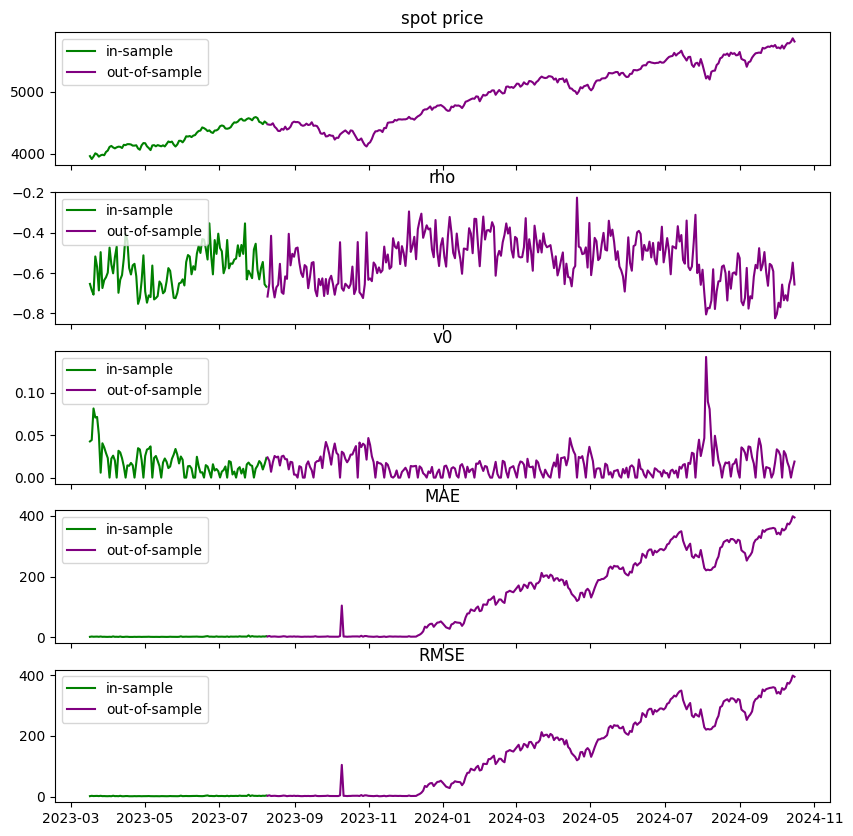

In [38]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

def plot_errors(train_data,test_data):
    test_diff = test_data['outofsample_error']
    train_diff = train_data['insample_error']
    
    test_plot = test_data[['date','spot_price','rho','v0']].copy()
    test_plot = test_plot.reset_index().set_index('date')
    test_plot['MAE'] = test_diff.resample('D').apply(compute_RMSE)
    test_plot['RMSE'] = test_diff.resample('D').apply(compute_RMSE)
    test_plot = test_plot.reset_index()
    test_plot = test_plot.drop_duplicates(subset=['date'],keep='last').set_index('date').drop(columns='calculation_date')
    
    train_plot = train_data[['date','spot_price','rho','v0']].copy()
    train_plot = train_plot.reset_index().set_index('date')
    train_plot['MAE'] = train_diff.resample('D').apply(compute_RMSE)
    train_plot['RMSE'] = train_diff.resample('D').apply(compute_RMSE)
    train_plot = train_plot.reset_index()
    train_plot = train_plot.drop_duplicates(subset=['date'],keep='last').set_index('date').drop(columns='calculation_date')

    
    trainx = pd.date_range(start=min(train_data.index),end=max(train_data.index),periods=train_plot.shape[0])
    testx = pd.date_range(start=min(test_data.index),end=max(test_data.index),periods=test_plot.shape[0])

    train_plot.index = trainx
    test_plot.index = testx
    
    
    fig,axs = plt.subplots(max(len(train_plot.columns),len(test_plot.columns)),figsize=(10,10),sharex=True)
    for i,col in enumerate(train_plot.columns):
        axs[i].plot(train_plot[col],color='green',label='in-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    for i,col in enumerate(test_plot.columns):
        axs[i].plot(test_plot[col],color='purple',label='out-of-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    plt.show()



train_data = model['train_data'].copy()
test_data = model['test_data'].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'],format='mixed')
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'],format='mixed')
test_data = test_data.set_index('calculation_date').sort_index()
train_data = train_data.set_index('calculation_date').sort_index()
plot_errors(train_data,test_data)

# retraining

In [40]:
from convsklearn import convsklearn
help(convsklearn)

Help on class convsklearn in module convsklearn.convsklearn:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object




training on 221958 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 31.3729031085968

in sample:
     RMSE: 1.9621670080637021
     MAE: 1.2168754346583572

out of sample:
     RMSE: 72.83859817242308
     MAE: 50.67165115174172


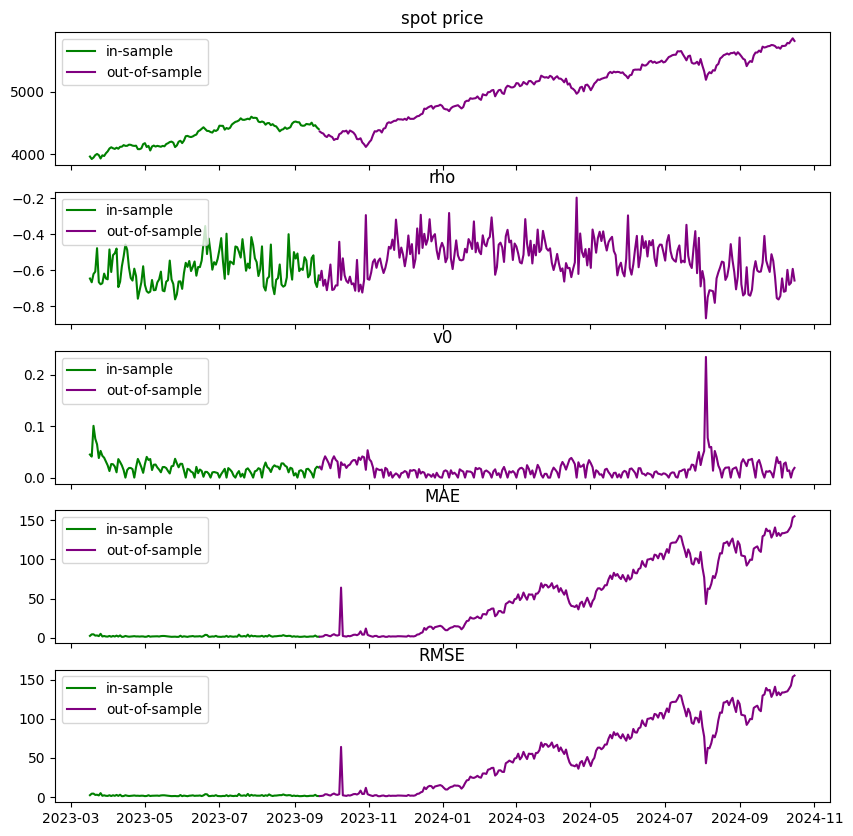



training on 278301 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 41.27749848365784

in sample:
     RMSE: 1.207433247275349
     MAE: 0.7295344830316332

out of sample:
     RMSE: 215.7194782387785
     MAE: 161.87115379554615


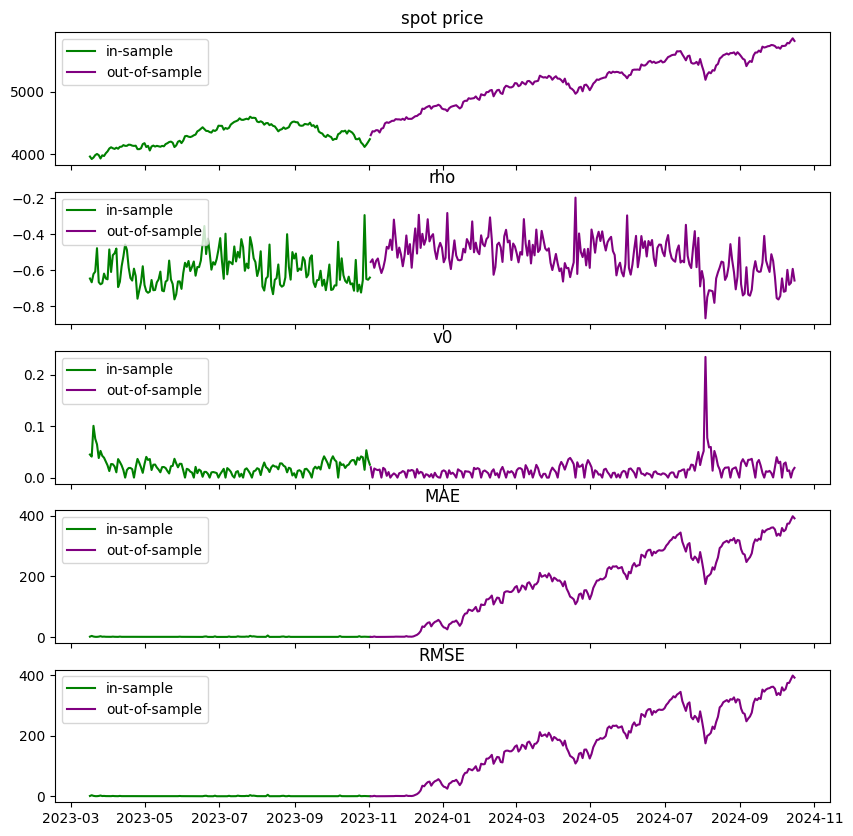



training on 322950 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 47.83390021324158

in sample:
     RMSE: 1.017089910688352
     MAE: 0.6230386022038913

out of sample:
     RMSE: 141.61301677957883
     MAE: 113.54175394323543


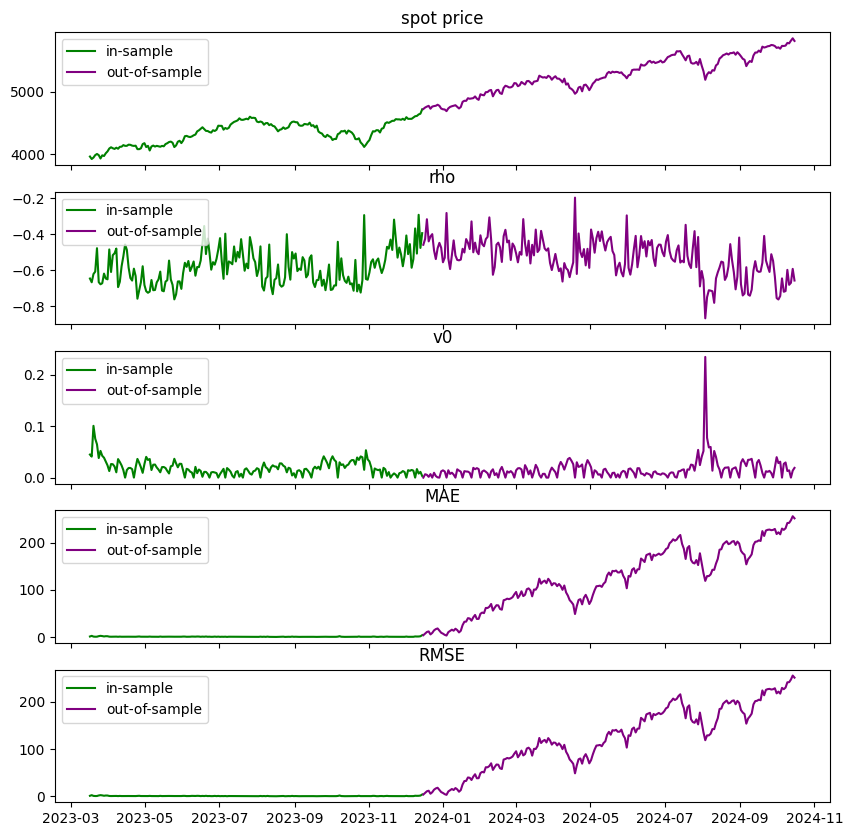



training on 368860 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 58.132320404052734

in sample:
     RMSE: 1.7967127313231286
     MAE: 1.066208302015189

out of sample:
     RMSE: 44.570811698075275
     MAE: 28.422078795221935


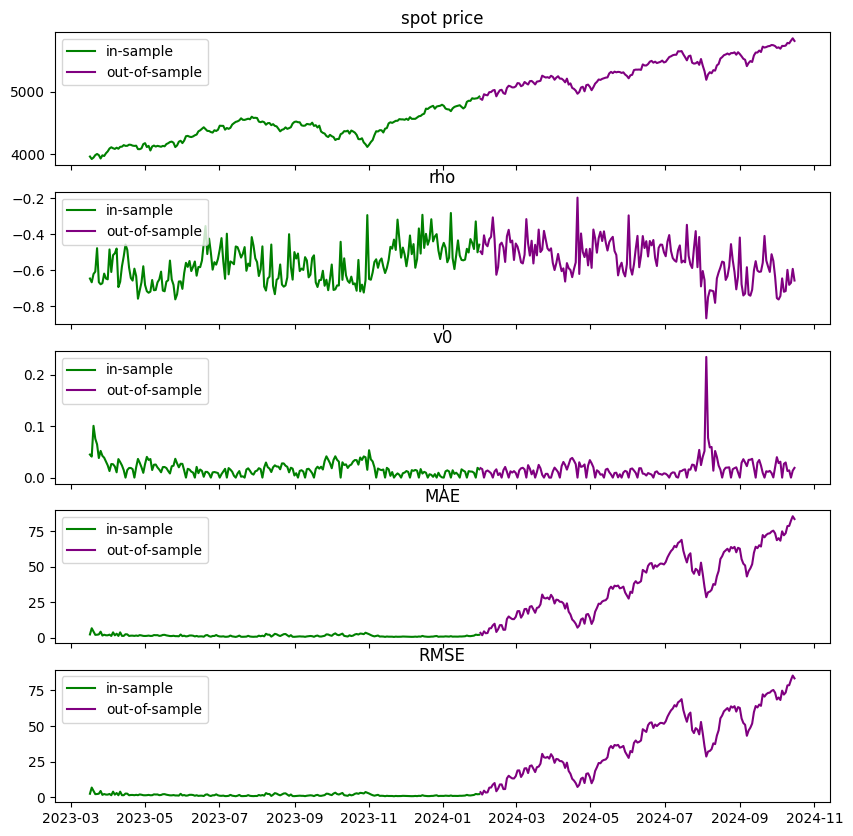



training on 419077 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 62.90994453430176

in sample:
     RMSE: 1.113786110684839
     MAE: 0.6255870083278792

out of sample:
     RMSE: 77.20077732771904
     MAE: 41.46838650716509


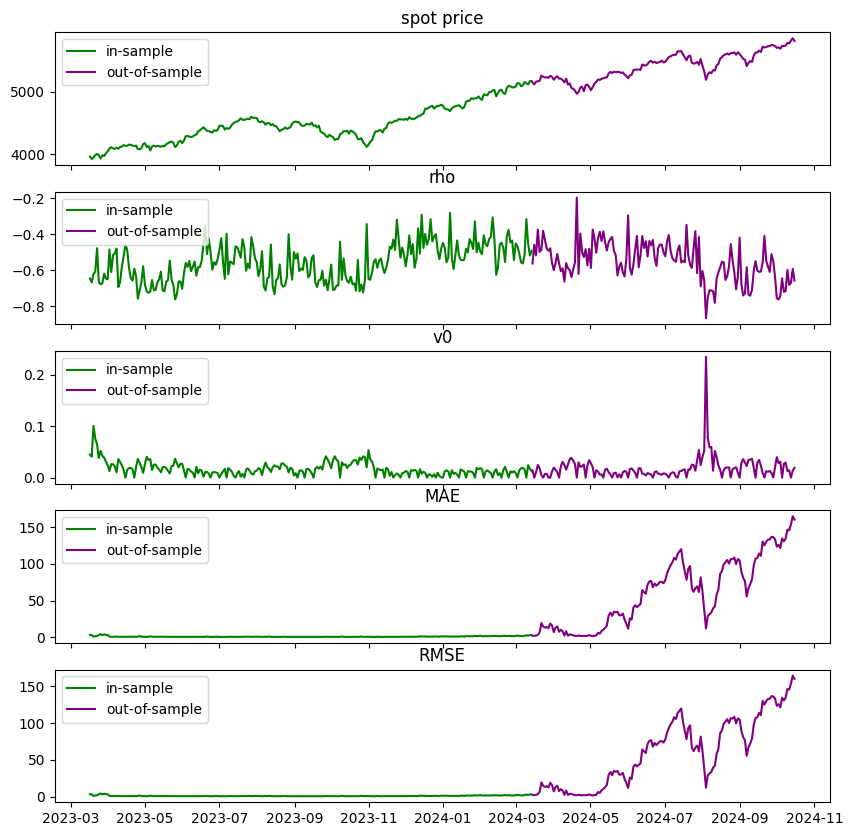



training on 471042 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 76.06193327903748

in sample:
     RMSE: 21.242712479265407
     MAE: 2.729654920859505

out of sample:
     RMSE: 14.689257827712838
     MAE: 3.9574047549841427


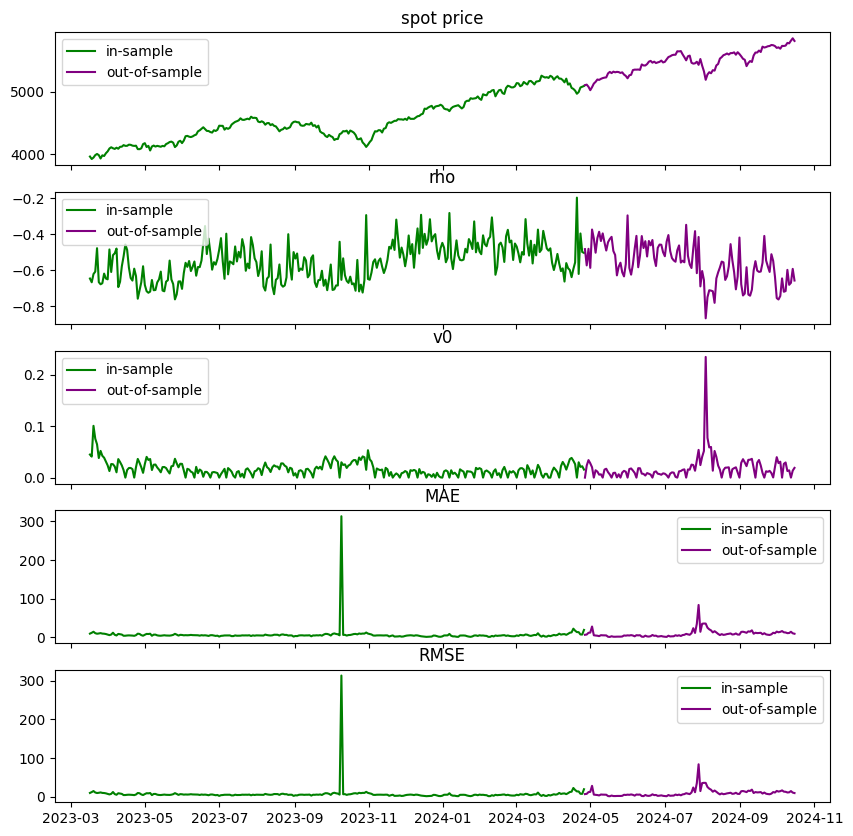



training on 511848 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 69.99032044410706

in sample:
     RMSE: 1.0161562197226255
     MAE: 0.5541982843123342

out of sample:
     RMSE: 60.27511035249309
     MAE: 37.051441315923384


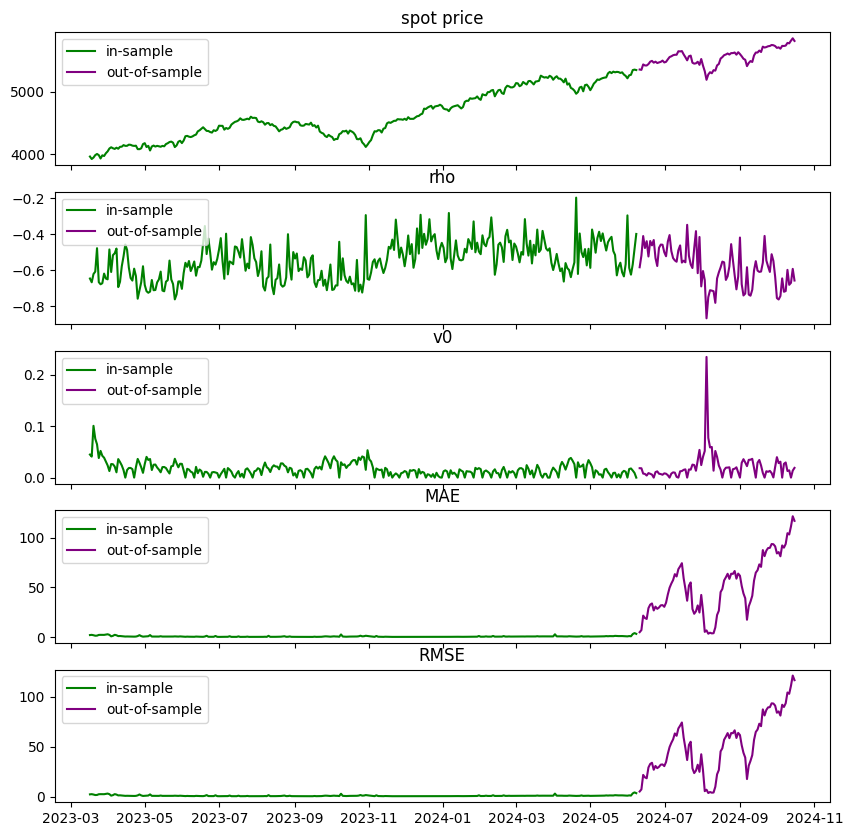



training on 552467 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 82.41364455223083

in sample:
     RMSE: 0.2871240837862174
     MAE: 0.19744021454994756

out of sample:
     RMSE: 2.0678720580773637
     MAE: 0.6086019827774417


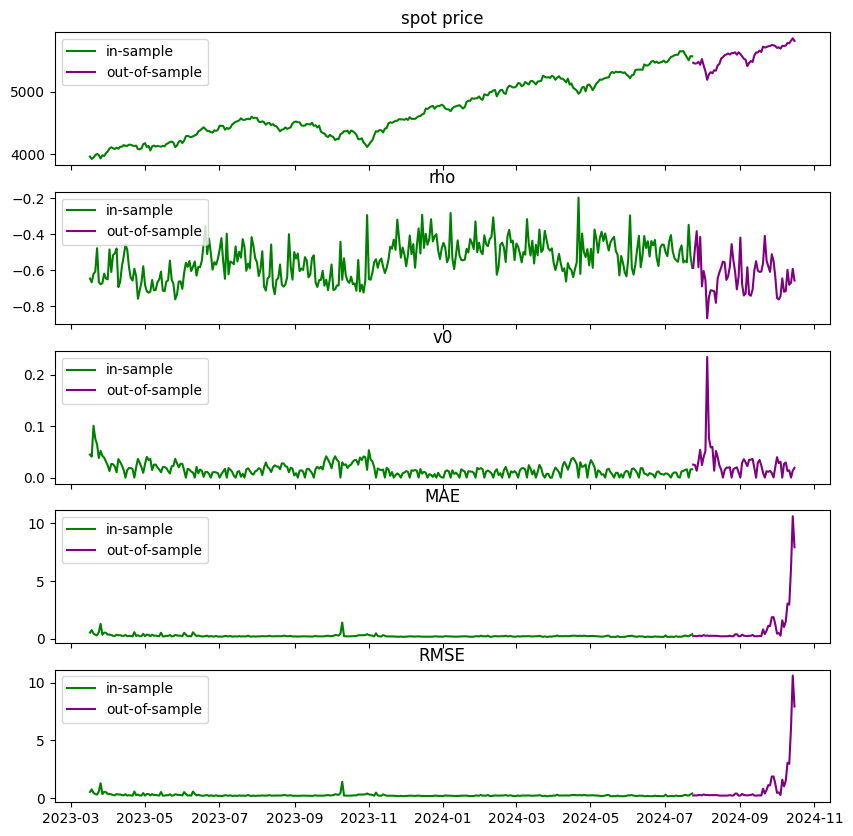



training on 604137 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 96.12209987640381

in sample:
     RMSE: 0.12510751307090764
     MAE: 0.06364703474845504

out of sample:
     RMSE: 15.80885696674977
     MAE: 5.620448306451588


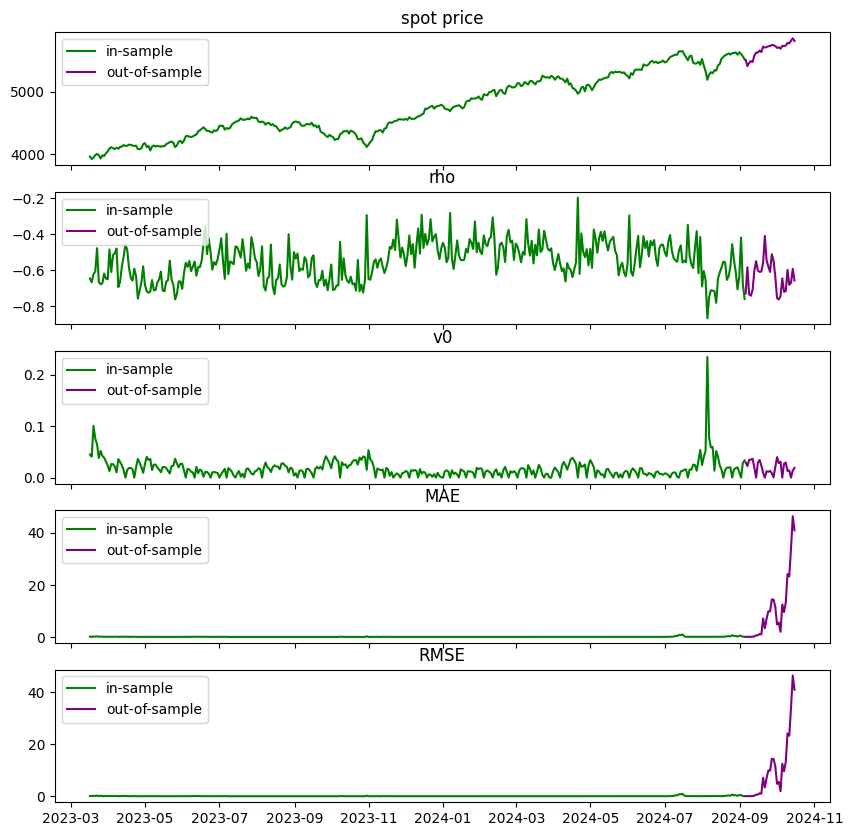



training on 656647 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 91.56787538528442


In [43]:
retraining_frequency = 30 #days
test_dates = model['test_dates']
full_dataset = model['dataset']
models = {}
for i, date in enumerate(test_dates):
    development_dates = pd.concat([model['development_dates'],test_dates[:(i+1)*retraining_frequency]])
    subset_test_dates = test_dates[~test_dates.isin(development_dates)]
    if development_dates.shape == 0:
        break
    try:
        retrainer = convsklearn()
        retrainer.load_data(full_dataset)
        retrainer.preprocess_data(development_dates, subset_test_dates,plot=False)
        retrainer.run_dnn()
        retrainer.test_prediction_accuracy()
        models[date] = retrainer.__dict__
        plot_errors(retrainer.train_data.set_index('calculation_date'),retrainer.test_data.set_index('calculation_date'))
        print()
    except Exception as e:
        if str(e).find('Found array with 0 sample(s)')==-1:
            print(e)
        break

In [45]:
pd.concat([model['development_dates'],model['test_dates']])

0      2023-03-16
1      2023-03-17
2      2023-03-20
3      2023-03-21
4      2023-03-22
          ...    
394    2024-10-09
395    2024-10-10
396    2024-10-11
397    2024-10-14
398    2024-10-15
Length: 399, dtype: object

In [46]:
for k,m in models.items():
    print(k)
    print(m['test_data'].iloc[:,-4:].describe())
    print()
    print('%'*20)

2023-08-09
       observed_price  outofsample_target  outofsample_prediction  \
count   434689.000000       434689.000000           434689.000000   
mean      1557.725800         1557.725800             1606.990365   
std        919.198017          919.198017              922.580661   
min         41.159813           41.159813               14.789337   
25%       1114.788312         1114.788312             1115.001972   
50%       1363.688955         1363.688955             1490.132685   
75%       2488.197847         2488.197847             2504.530514   
max       2938.135999         2938.135999             3063.498234   

       outofsample_error  
count      434689.000000  
mean           49.264566  
std            53.651380  
min          -213.061855  
25%             1.245129  
50%            37.247481  
75%            78.833949  
max           415.473337  

%%%%%%%%%%%%%%%%%%%%
2023-08-10
       observed_price  outofsample_target  outofsample_prediction  \
count   378346.000000 

In [47]:
joblib.dump(models,'asian_options_retraining_test.pkl')

['asian_options_retraining_test.pkl']